In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
path = os.path.abspath('/content/gdrive/Shared drives/2040_project/LSY ARCHIVE/models')
# os.mkdir(os.path.join(path, 'bw_4thIter'))
# path = os.path.join(path, 'bw_4thIter')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# # this part will prevent tensorflow to allocate all the avaliable GPU Memory
# # backend
%tensorflow_version 2.x
import tensorflow as tf
# from keras import backend as k

# # Don't pre-allocate memory; allocate as-needed
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# # Create a session with the above options specified.
# k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, SpatialDropout2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from keras.layers import Concatenate
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.metrics import mean_squared_error
from scipy import spatial
import re

Using TensorFlow backend.


# 1.Load Model

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 100
l = 12
num_filter = 36 #added 24 more filters
compression = 0.5 
dropout_rate = 0.2
img_height, img_width, channel = 32, 32, 3

In [0]:
# Dense Block
# removed the dropout
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #if dropout_rate>0:
         # Conv2D_3_3 = Dropout2D(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False, kernel_regularizer = regularizers.l1() ,padding='same')(relu)
    #if dropout_rate>0:
      #Conv2D_BottleNeck = Dropout2D(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
# converted the last Dense Layer to a Fully Convolution N/w as use of Dense Layer was prohibited
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    temp = Conv2D(num_classes, kernel_size = (2,2))(AvgPooling)
    output = Activation('softmax')(temp)
    flat = Flatten()(output)
    
    return flat

In [0]:
num_filter = 36
dropout_rate = 0.2
l= 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 36)   972         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 36)   144         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 36)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
model.load_weights(path + '/190epochs.h5')

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01, momentum = 0.7),
              metrics=['accuracy'])

# 2.Load Image

In [0]:
# Load CIFAR10 Data
import numpy as np
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = tf.image.rgb_to_grayscale(x_train, name=None)
x_train = tf.broadcast_to(x_train, [50000, 32, 32, 3])
x_test = tf.image.rgb_to_grayscale(x_test, name=None)
x_test = tf.broadcast_to(x_test, [10000, 32, 32, 3])
x_train = x_train.numpy()
x_test = x_test.numpy()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 11s 0us/step


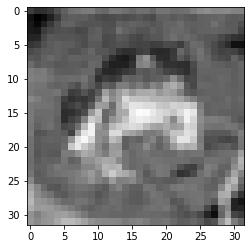

In [0]:
img_tensor = x_train[0]
img_tensor = np.expand_dims(img_tensor, axis=0)
plt.imshow(img_tensor[0])

# 3.Reduce Number of Filters

## 3.1 Visualize filters

In [0]:
def deprocess_image_grayscale_for_plot(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')

    # convert to grayscale by averaging across 3 channels
    # x = np.mean(x, axis=2)
    x = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])

    return x


def deprocess_image_grayscale(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to grayscale by averaging across 3 channels
    # x = np.mean(x, axis=2)
    x = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])

    return x


def deprocess_image_color(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(model, layer_name, filter_index, size=32, grayscale=True, for_plot=False):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 0.5
    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]

    if grayscale:
        if not for_plot:
            return deprocess_image_grayscale(img)
        else:
            return deprocess_image_grayscale_for_plot(img)

    if not grayscale:
        return deprocess_image_color(img)

In [0]:
def plot_filters(model_name, layer_list, img_size, mar, row = 3, col = 6, greyscale_flag = True, plot_flag = True, col_customized=None):

    for layer_name in layer_list:
        size = img_size
        margin = mar
        for_trans = []
        if not greyscale_flag:
            results = np.zeros((row * size + 7 * margin, col * size + 7 * margin, 3))
        else:
            # This a empty (black) image where we will store our results.
            results = np.zeros((row * size + 7 * margin, col * size + 7 * margin))

        for i in range(row):  # iterate over the rows of our results grid
            for j in range(col):  # iterate over the columns of our results grid
                # Generate the pattern for filter `i + (j * 6)` in `layer_name`
                
                filter_img = generate_pattern(model_name, layer_name, j + (i * row), size=size, grayscale=greyscale_flag, for_plot=plot_flag)
                  
                # Put the result in the square `(i, j)` of the results grid
                horizontal_start = i * size + i * margin
                horizontal_end = horizontal_start + size
                vertical_start = j * size + j * margin
                vertical_end = vertical_start + size
                if not greyscale_flag:
                    results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img/255
                else:
                    results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img / 255
                #print(np.amin(filter_img[:]), np.amax(filter_img[:]))
            print('Finished filter no.', j + (i * row), "in", layer_name, end= '.  ')
        # Display the results grid
        print(layer_name)
        plt.figure(figsize=(15, 15))
        if col_customized:
            plt.imshow(results, cmap=col_customized)
        else:
            plt.imshow(results)
        plt.show()

### 3.1.4 All Filters Result in Grayscale

Finished filter no. 5 in conv2d_1.  Finished filter no. 11 in conv2d_1.  Finished filter no. 17 in conv2d_1.  Finished filter no. 23 in conv2d_1.  Finished filter no. 29 in conv2d_1.  Finished filter no. 35 in conv2d_1.  conv2d_1


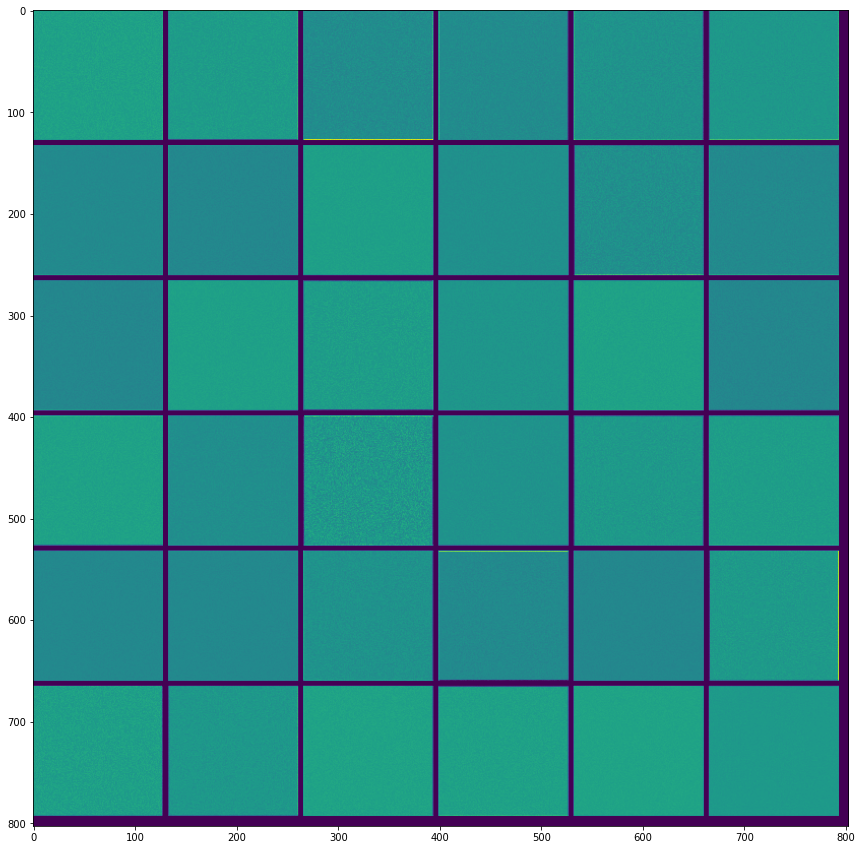

In [0]:
plot_filters(model, ["conv2d_1"], 128, 5, row = 6, col = 6, greyscale_flag = True, plot_flag = True)

### 3.1.5 All Filters in Color

finished: 0, finished: 6, finished: 12, finished: 18, finished: 24, finished: 30, finished: 1, finished: 7, finished: 13, finished: 19, finished: 25, finished: 31, finished: 2, finished: 8, finished: 14, finished: 20, finished: 26, finished: 32, finished: 3, finished: 9, finished: 15, finished: 21, finished: 27, finished: 33, finished: 4, finished: 10, finished: 16, finished: 22, finished: 28, finished: 34, finished: 5, finished: 11, finished: 17, finished: 23, finished: 29, finished: 35, conv2d_1


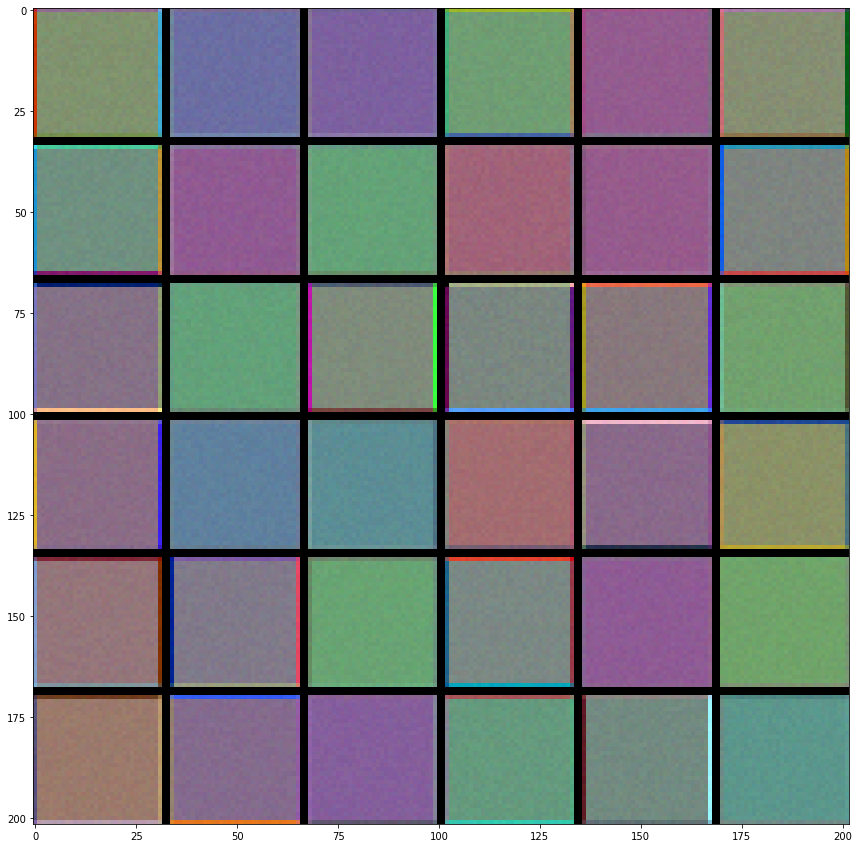

In [0]:
plot_filters(model, ["conv2d_1"], 128, 5, row = 6, col = 6, greyscale_flag = False, plot_flag = True)

Finished filter no. 5 in conv2d_2.  Finished filter no. 8 in conv2d_2.  Finished filter no. 11 in conv2d_2.  conv2d_2


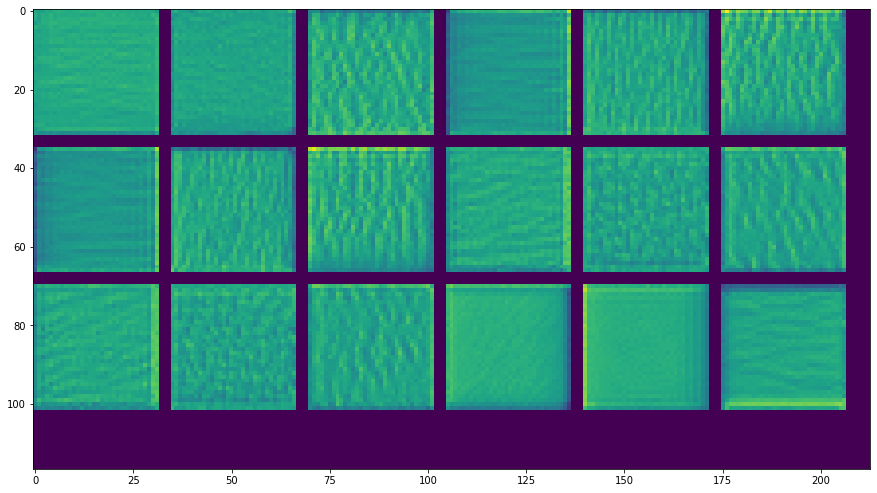

In [0]:
plot_filters(model, ['conv2d_2'], 32, 3, row = 3, col = 6, greyscale_flag = True, plot_flag=False)

Finished filter no. 5 in conv2d_3.  Finished filter no. 8 in conv2d_3.  Finished filter no. 11 in conv2d_3.  conv2d_3


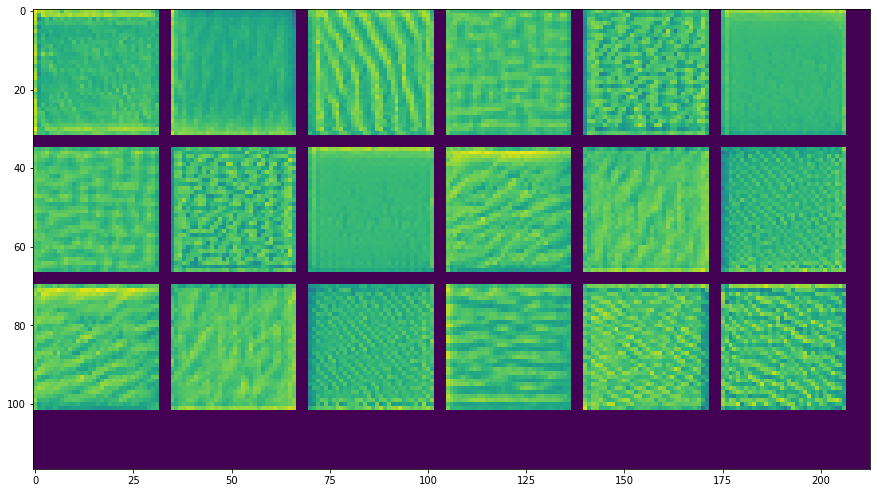

In [0]:
plot_filters(model, ['conv2d_3'], 32, 3, row = 3, col = 6, greyscale_flag = True, plot_flag=False)

## 3.2 Cluster Filters

In [0]:
# collect all filter visualizations as np arrays
filter_collection = []
for i in range(36):
    filter_img_temp = generate_pattern(model, 'conv2d_1', i, size=32, grayscale=True, for_plot=False)
    filter_collection.append(filter_img_temp)
filter_collection = np.array(filter_collection)

In [0]:
# calculate distance matrix using ssim
filter_distance_matrix_ssim = np.zeros((36, 36))
for i in range(36):
    for j in range(36):
        filter_distance_matrix_ssim[i, j] = \
        ssim(filter_collection[i], filter_collection[j])
filter_distance_matrix_ssim = 1 - filter_distance_matrix_ssim

In [0]:
# calculate distance matrix using mse
filter_distance_matrix_mse = np.zeros((36, 36))
for i in range(36):
    for j in range(36):
        filter_distance_matrix_mse[i, j] = \
        mean_squared_error(filter_collection[i].flatten(), filter_collection[j].flatten())

In [0]:
# calculate distance matrix using cosine
filter_distance_matrix_cosine = np.zeros((36, 36))
for i in range(36):
    for j in range(36):
        filter_distance_matrix_cosine[i, j] = \
        1 - spatial.distance.cosine(filter_collection[i].flatten(), filter_collection[j].flatten())
filter_distance_matrix_cosine = 1 - filter_distance_matrix_cosine

In [0]:
for_std = np.array([filter_distance_matrix_mse[i, j] for i in range(36) for j in range(36) if i != j])

In [0]:
clustering = DBSCAN(eps=np.std(for_std) * 0.2, 
                    min_samples=1, metric='precomputed').fit(filter_distance_matrix_mse)

In [0]:
filter_clusters_1 = clustering.labels_
print(max(filter_clusters_1) + 1)
filter_clusters_1.reshape((6, 6))

20


array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  6,  7,  6,  8,  6],
       [ 6,  7,  9, 10,  7,  6],
       [ 7,  6, 11,  6, 12, 13],
       [ 6,  6, 10, 14,  6, 15],
       [16, 17, 18, 19,  7, 13]])

In [0]:
filter_clusters_2 = np.array([0, 0, 1, 2, 3, 4, 
                              0, 5, 6,  7,  7, 8, 
                              9, 2, 2, 10, 11, 0])
print(max(filter_clusters_2) + 1)
filter_clusters_2.reshape((3, 6))

12


array([[ 0,  0,  1,  2,  3,  4],
       [ 0,  5,  6,  7,  7,  8],
       [ 9,  2,  2, 10, 11,  0]])

In [0]:
concat_cluster = np.concatenate((filter_clusters_1, filter_clusters_2 + max(filter_clusters_1) + 1))
print(len(concat_cluster))
concat_cluster

54


array([ 0,  1,  2,  3,  4,  5,  6,  6,  7,  6,  8,  6,  6,  7,  9, 10,  7,
        6,  7,  6, 11,  6, 12, 13,  6,  6, 10, 14,  6, 15, 16, 17, 18, 19,
        7, 13, 20, 20, 21, 22, 23, 24, 20, 25, 26, 27, 27, 28, 29, 22, 22,
       30, 31, 20])

## 3.3 Merge Filters

In [0]:
def merge_filters(original_weights, cluster_res, 
                  cluster_res_prev=np.array([0, 0, 0]), layer_type='conv'):
    """
    Merge original weights, 
    based on clustering results and number of in_channels
    """

    # clean clustering result for outliers, record them as a new cluster
    max_cluster = max(cluster_res)
    for i, cls in enumerate(cluster_res):
        if cls == -1:
            max_cluster += 1
            cluster_res[i] = max_cluster
        
    # clean prev clustering result for outliers, record them as a new cluster
    max_cluster_prev = max(cluster_res_prev)
    for i, cls in enumerate(cluster_res_prev):
        if cls == -1:
            max_cluster_prev += 1
            cluster_res_prev[i] = max_cluster_prev

    if layer_type == 'conv':
        # average over the 4th dimension
        # zero tensor to record weights
        clustered_weights = np.zeros(list(original_weights.shape[:3]) + [max_cluster + 1])

        # load new filters with averaged weights
        for filter_idx in range(max_cluster + 1):
            # get index for the filters belong to that cluster
            idx = tf.constant([i for i in range(len(cluster_res)) if cluster_res[i] == filter_idx])
            # reduce average over the filters
            clustered_filter = tf.reduce_mean(tf.gather(original_weights, idx, axis=3), axis=3)
            clustered_weights[:, :, :, filter_idx] = clustered_filter

        # sum over the 3rd dimension according to previous cluster results
        # zero tensor to record weights
        reduced_clustered_weights = np.zeros(list(original_weights.shape[:2]) + [max_cluster_prev + 1] + [max_cluster + 1])

        # load new filters with sumed weights
        for filter_idx in range(max_cluster_prev + 1):
            # get index for the filters belong to that cluster
            idx = tf.constant([i for i in range(len(cluster_res_prev)) if cluster_res_prev[i] == filter_idx])
            # reduce average over the filters
            sumed_filter = tf.reduce_sum(tf.gather(clustered_weights, idx, axis=2), axis=2)
            reduced_clustered_weights[:, :, filter_idx, :] = sumed_filter

        return reduced_clustered_weights

    if layer_type == 'bn':
        # average the weights across channels
        # list to record weights
        clustered_weights = [np.zeros([max_cluster + 1]), 
                             np.zeros([max_cluster + 1]), 
                             np.zeros([max_cluster + 1]), 
                             np.zeros([max_cluster + 1])]

        # load new filters with averaged weights
        for bn_idx, bn_weights in enumerate(clustered_weights):
            for filter_idx in range(max_cluster + 1):
                # get index for the filters belong to that cluster
                idx = tf.constant([i for i in range(len(cluster_res)) if cluster_res[i] == filter_idx])
                # reduce average over the filters
                clustered_filter = tf.reduce_mean(tf.gather(original_weights[bn_idx], idx, axis=0), axis=0)
                bn_weights[filter_idx] = clustered_filter
        return clustered_weights

In [0]:
test_conv_1 = merge_filters(model.get_layer('conv2d_1').weights[0], 
                            filter_clusters_1, np.array([0, 0, 0]), layer_type='conv')
test_conv_1.shape

(3, 3, 1, 20)

In [0]:
test_bn_1 = merge_filters(model.get_layer('batch_normalization_1').weights, 
                          filter_clusters_1, layer_type='bn')
test_bn_1[0].shape

(20,)

In [0]:
test_conv_2 = merge_filters(model.get_layer('conv2d_2').weights[0], 
                            filter_clusters_2, filter_clusters_1, layer_type='conv')
test_conv_2.shape

(3, 3, 20, 12)

## 3.4 Load Weights

In [0]:
# Dense Block
# removed the dropout
def add_denseblock_clustered(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input

    BatchNorm = BatchNormalization()(temp)
    relu = Activation('relu')(BatchNorm)
    Conv2D_3_3 = Conv2D(int(12), (3,3), use_bias=False ,padding='same')(relu)
    concat = Concatenate(axis=-1)([temp, Conv2D_3_3])
    temp = concat

    for _ in range(l - 1):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat
        
    return temp

In [0]:
num_filter = 36
dropout_rate = 0.2
l= 12
input = Input(shape=(img_height, img_width, 1,))
First_Conv2D = Conv2D(test_conv_1.shape[-1], (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock_clustered(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

model_clustered = Model(inputs=[input], outputs=[output])

In [0]:
model_clustered.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 32, 32, 20)   180         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_105 (BatchN (None, 32, 32, 20)   80          conv2d_107[0][0]                 
__________________________________________________________________________________________________
activation_107 (Activation)     (None, 32, 32, 20)   0           batch_normalization_105[0][0]    
____________________________________________________________________________________________

In [0]:
# load previous weights
layer_weight_dic = {}
for layer_idx in range(len(model.layers)):
    layer_name_clustered = model_clustered.layers[layer_idx].name
    layer_weights_prev = model.layers[layer_idx].get_weights()
    layer_weight_dic[layer_name_clustered] = layer_weights_prev

In [0]:
# update to new weights
layer_weight_dic['conv2d_107'] = [test_conv_1]
layer_weight_dic['conv2d_108'] = [test_conv_2]
layer_weight_dic['batch_normalization_105'] = test_bn_1
conv_count = 109
bn_count = 106
num_clusters = max(concat_cluster) + 1

for i in range(12):
    # get new height for conv and bn
    ttl_dim = model_clustered.get_layer(f'conv2d_{conv_count}').weights[0].shape[2]

    # update conv dimension
    tmp_wt_conv = merge_filters(model.get_layer(f'conv2d_{conv_count - 106}').weights[0], 
                            np.arange(18),
                            np.concatenate((concat_cluster, np.arange(num_clusters, ttl_dim))), 
                            layer_type='conv')
    layer_weight_dic[f'conv2d_{conv_count}'] = [tmp_wt_conv]

    # update bn dimension
    tmp_wt_bn = merge_filters(model.get_layer(f'batch_normalization_{bn_count - 104}').weights, 
                          np.concatenate((concat_cluster, np.arange(num_clusters, ttl_dim))), 
                          layer_type='bn')
    layer_weight_dic[f'batch_normalization_{bn_count}'] = tmp_wt_bn

    conv_count += 1
    bn_count += 1

In [0]:
# load new weights to model
for layer in model_clustered.layers:
    # print(layer.name)
    try:
        layer.set_weights(layer_weight_dic[layer.name])
    except ValueError:
        print(layer.name, 'need shape:', layer.get_weights()[0].shape, \
              ', got shape:', layer_weight_dic[layer.name][0].shape)

In [0]:
# determine Loss function and Optimizer for the new model
model_clustered.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01, momentum = 0.7),
              metrics=['accuracy'])

# 5.Testing

## 5.1 Raw Results

### 5.1.1 Original Model

In [0]:
_, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
test_accuracy

0.8320000171661377

### 5.1.2 Clustered Model

In [0]:
_, test_accuracy_clustered = model_clustered.evaluate(np.expand_dims(x_test[:, :, :, 0], axis=3), y_test, verbose=0)
test_accuracy_clustered

0.7372999787330627

In [0]:
# Save model
model_name = 'densenet_clustered_2_layer.h5'
model_clustered.save(model_name)

## 5.2 Only Train BN Layers

### 5.2.1 Original Model

In [0]:
for layer in model.layers:
    if 'batch_normalization' not in layer.name:
        layer.trainable = False

# determine Loss function and Optimizer for the new model
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01, momentum = 0.7),
              metrics=['accuracy'])

In [0]:
model.fit(x_train, y_train, epochs = 1, verbose=0, 
                    validation_data = (x_test, y_test))

In [0]:
_, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
test_accuracy

0.869700014591217

### 5.2.2 Clustered Model

In [0]:
for layer in model_clustered.layers:
    if 'batch_normalization' not in layer.name:
        layer.trainable = False

# determine Loss function and Optimizer for the new model
model_clustered.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01, momentum = 0.7),
              metrics=['accuracy'])

In [0]:
model_clustered.fit(np.expand_dims(x_train[:, :, :, 0], axis=3), y_train, epochs = 1, verbose=0, 
                    validation_data = (np.expand_dims(x_test[:, :, :, 0], axis=3), y_test))

In [0]:
_, test_accuracy_clustered = model_clustered.evaluate(np.expand_dims(x_test[:, :, :, 0], axis=3), y_test, verbose=0)
test_accuracy_clustered

0.8482999801635742

In [0]:
# Save model
model_name = 'densenet_clustered_2_layer_bn_trained.h5'
model_clustered.save(model_name)